<a href="https://colab.research.google.com/github/MaggieWelch/labs/blob/main/MWHedonicPricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Clean the data and perform some EDA and visualization to get to know the data set

In [290]:
import pandas as pd
url ='https://raw.githubusercontent.com/DS3001/labs/refs/heads/main/04_hedonic_pricing/airbnb_hw.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(30478, 13)


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [291]:
#dropping columns that are unnessesary to the price, such as host information and ratings
columns_to_drop = ['Host Id', 'Host Since','Name', 'Review Scores Rating (bin)', 'Number Of Reviews', 'Review Scores Rating', 'Number of Records']
df = df.drop(columns=columns_to_drop)
print(df.columns)

Index(['Neighbourhood ', 'Property Type', 'Room Type', 'Zipcode', 'Beds',
       'Price'],
      dtype='object')


In [292]:
#removing unnecessary space after Neighbourhood and renaming it to Neighborhood
df.rename(columns={'Neighbourhood ': 'Neighborhood'}, inplace=True)
print(df.columns)


Index(['Neighborhood', 'Property Type', 'Room Type', 'Zipcode', 'Beds',
       'Price'],
      dtype='object')


In [293]:
print(df.dtypes)

Neighborhood      object
Property Type     object
Room Type         object
Zipcode          float64
Beds             float64
Price             object
dtype: object


In [294]:
# Remove convert Price to float
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

In [295]:
#looking for NA inputs
print(df.isna().sum())

Neighborhood       0
Property Type      3
Room Type          0
Zipcode          134
Beds              85
Price              0
dtype: int64


In [296]:
#since there is not a significant amount of NA values, dropping them from df
df = df.dropna()
print(df.shape)

(30257, 6)


In [297]:
#Organizing price data for EDA box plot to understand general trends preanalysis
print(df['Price'].min())
print(df['Price'].max())

10.0
10000.0


In [298]:
import pandas as pd

# Define bins as floats and create labels
bins = [10 + i * 100 for i in range(11)]  # Creates 10 bins: $10, $110, $210, ..., $910, $1000
labels = [f"${bins[i]} - ${bins[i+1]}" for i in range(len(bins) - 1)]

# Bin the 'price' variable
df['price_bin'] = pd.cut(df['Price'], bins=bins, labels=labels, include_lowest=True)

# Display the first few rows with the new 'price_bin' column
print(df[['Price', 'price_bin']].head())


   Price    price_bin
0  145.0  $110 - $210
1   37.0   $10 - $110
2   28.0   $10 - $110
3  199.0  $110 - $210
4  549.0  $510 - $610


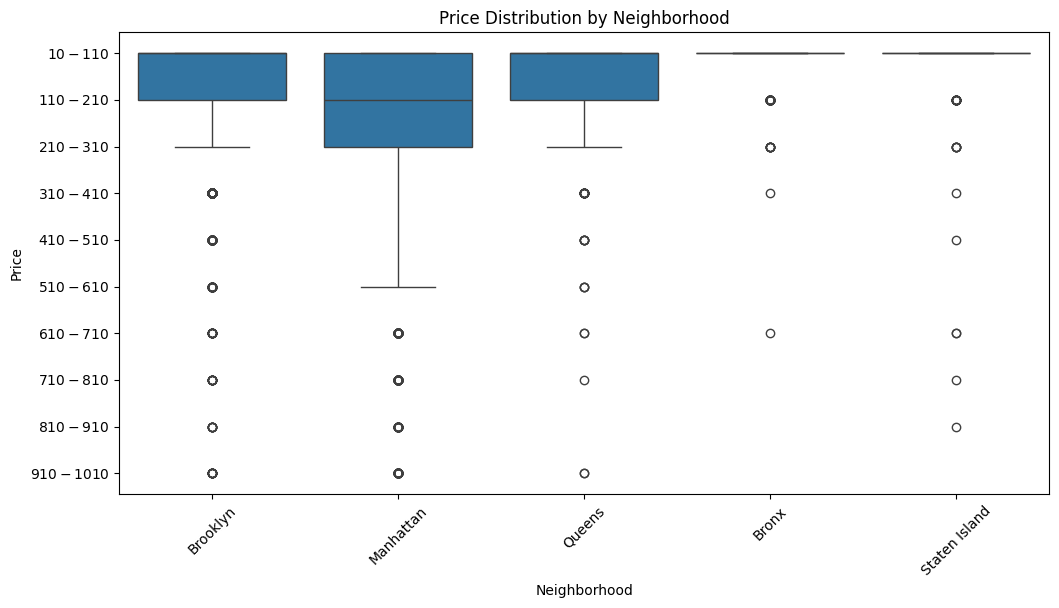

In [299]:
#Box plot of price by neighborhood
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.boxplot(x='Neighborhood', y='price_bin', data=df)

plt.title("Price Distribution by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Price")
plt.xticks(rotation=45)

plt.show()

significant amount of outliers in data set

In [300]:
#remove bin variable from df, as that was just for the EDA Boxplot
df= df.drop('price_bin', axis=1)
#removing property type from data set to focus on better features
df = df.drop('Property Type', axis=1)

# 2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [301]:
#Transform categorical variables using one-hot encoding
df_transformed = pd.get_dummies(df, columns=['Neighborhood', 'Room Type'], drop_first=True)
print(df_transformed.head())

   Zipcode  Beds  Price  Neighborhood_Brooklyn  Neighborhood_Manhattan  \
0  11249.0   1.0  145.0                   True                   False   
1  11206.0   1.0   37.0                   True                   False   
2  10032.0   1.0   28.0                  False                    True   
3  10024.0   3.0  199.0                  False                    True   
4  10036.0   3.0  549.0                  False                    True   

   Neighborhood_Queens  Neighborhood_Staten Island  Room Type_Private room  \
0                False                       False                   False   
1                False                       False                    True   
2                False                       False                    True   
3                False                       False                   False   
4                False                       False                    True   

   Room Type_Shared room  
0                  False  
1                  False  
2    

# 3. Implement an ~80/~20 train-test split. Put the test data aside.

In [302]:
from sklearn.model_selection import train_test_split
# Separate features (X) and target variable (y)
X = df_transformed.drop(columns=['Price'])
y = df_transformed['Price']

#80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#checking shape of split data
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (24205, 8)
Testing set size: (6052, 8)


# 4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and R^2 on the both the training and test sets. Which of your models does the best?

In [303]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Calculate RMSE and R^2 for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R^2 for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display the results
print(f"Training Set RMSE: {train_rmse}")
print(f"Training Set R^2: {train_r2}")
print(f"Testing Set RMSE: {test_rmse}")
print(f"Testing Set R^2: {test_r2}")

Training Set RMSE: 180.88521914938923
Training Set R^2: 0.178903457910504
Testing Set RMSE: 169.5467624661269
Testing Set R^2: 0.1863371952572589


From this analysis, both the training and testing set's Root Mean Square Error are high, indicating that there is a high level of error in its predicitions. The R^2 of both the training and testing sets are fairly low, indicating that the model is not capturing underlying relationships well. That being said, while neither models, were great the testing set was better.  

# 5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and R^2 on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [304]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

#Define the pipeline
model = Pipeline([
    ("scaler", StandardScaler()),  # Scale features
    ("poly", PolynomialFeatures(degree=2, interaction_only=False)),  # Add polynomial terms and interactions
    ("regressor", LinearRegression())  # Linear regression model
])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate RMSE and R^2 for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R^2 for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print(f"Training Set RMSE: {train_rmse}")
print(f"Training Set R^2: {train_r2}")
print(f"Testing Set RMSE: {test_rmse}")
print(f"Testing Set R^2: {test_r2}")


Training Set RMSE: 178.87054637867996
Training Set R^2: 0.19709210271504596
Testing Set RMSE: 205.92655635779107
Testing Set R^2: -0.20030101926708888


The outputs from this complex model indicate that the model is overfitting, as there is a significant discrepancy between the training and testing results. The training set RMSE and R^2 are improved from the previous model, however more adjustment needs to be done to improve the model's fit. Outliars in price seen in the EDA indicate that the use of a different model, such as RANSAC, may be helpful as it is less suceptible to outliars.  

RANSAC Model Training Set RMSE: 194.40245567524008
RANSAC Model Training Set R^2: 0.05159997750775602
RANSAC Model Testing Set RMSE: 196.24682330038635
RANSAC Model Testing Set R^2: -0.0901110245173653


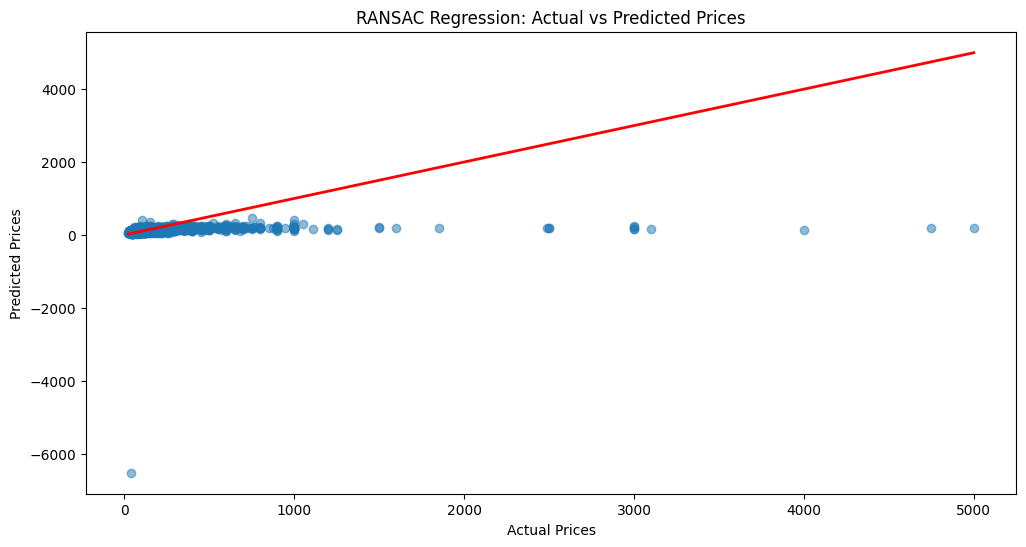

In [305]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize the base linear regression model
base_model = LinearRegression()

# Initialize the RANSAC regressor with the base model
ransac = RANSACRegressor(base_model, random_state=42)

# Fit the RANSAC model on the training data
ransac.fit(X_train, y_train)

# Predict on the training set
y_train_pred = ransac.predict(X_train)

# Predict on the test set
y_test_pred = ransac.predict(X_test)

# Calculate RMSE and R^2 for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R^2 for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print(f"RANSAC Model Training Set RMSE: {train_rmse}")
print(f"RANSAC Model Training Set R^2: {train_r2}")
print(f"RANSAC Model Testing Set RMSE: {test_rmse}")
print(f"RANSAC Model Testing Set R^2: {test_r2}")

# Optional: Visualize the results
plt.figure(figsize=(12, 6))

# Plot predictions vs actual for the test set
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('RANSAC Regression: Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Diagonal line
plt.show()


Use of RANSAC did not improve modeling, but rather made it worse. In the future, more steps need to be taken in EDA to minimize outliars.

# 6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?


From this lab, I have learned how difficult it is to find the right linear regression model for a data set. It is a process of trial and error, however my codes were still generally unsucessful in getting an accurate prediction. My R^2s in the initial simple linear regression were low, indicating that relationships were not captured and the data was underfit. When I tried to correct this through my next code, the model was significantly worse, and overfit to the training data. I attempted using the RANSAC method, which chatgbt suggested could be helpful in reducing influence of outliars, however the model fit worse than my simple linear regression. I have learned that it is a push and pull trying to balence over and underfitting. More steps should have been taken in data cleaning and EDA to account for outliars prior to analysis.

# 7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and R^2?

In [307]:
from sklearn.linear_model import Lasso
# Initialize the Lasso regression model
lasso_model = Lasso(alpha=0.5, random_state=42)

# Fit the model on the training data
lasso_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = lasso_model.predict(X_train)

# Predict on the test set
y_test_pred = lasso_model.predict(X_test)

# Calculate RMSE and R² for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R² for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print(f"Lasso Model Training Set RMSE: {train_rmse}")
print(f"Lasso Model Training Set R^2: {train_r2}")
print(f"Lasso Model Testing Set RMSE: {test_rmse}")
print(f"Lasso Model Testing Set R^2: {test_r2}")

# Get the coefficients and the selected features
selected_features = np.where(lasso_model.coef_ != 0)[0]
print("Selected Features (Indices):", selected_features)
print("Selected Features (Names):", X_train.columns[selected_features])

Lasso Model Training Set RMSE: 180.9408203203335
Lasso Model Training Set R^2: 0.17839859691577586
Lasso Model Testing Set RMSE: 169.57138503887236
Lasso Model Testing Set R^2: 0.18610084835130536
Selected Features (Indices): [0 1 3 4 6 7]
Selected Features (Names): Index(['Zipcode', 'Beds', 'Neighborhood_Manhattan', 'Neighborhood_Queens',
       'Room Type_Private room', 'Room Type_Shared room'],
      dtype='object')


It selected Zipcode, Beds, Manhattan, Queens, and whether or not a room was public or private as features that effect the price. Considering this makes up a majority of the variables, more regulation is needed to narrow down the most predictive features. The RMSE for the training set, as well as the testing set, are still high indicating it is not fitting well. the R^2 for both are about 18%, which is still fairly poor.